# Image Emotion Classifier Mini Project
By Ashley Chacon

This Google Collab is inspired by the [CNN Image TensorFlow tutorial](https://www.tensorflow.org/tutorials/images/classification) It creates an image classifier using a `tf.keras.Sequential` model, and loads data using `tf.keras.utils.image_dataset_from_directory`. The dataset used for training and testing is the [FER-2013 dataset](https://www.kaggle.com/datasets/ananthu017/emotion-detection-fer) found on [Kaggle.com](https://kaggle.com).



## Import TensorFlow and other libraries

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow.keras.layers import Activation, Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization


from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Download and explore the dataset

Download the emotion detection dataset from Kaggle.com: https://www.kaggle.com/datasets/ananthu017/emotion-detection-fer

After download, you will have to upload the dataset to this Google Collab. Select the files tab on the lefthand tool bar, and upload manually from your computer downloads.

After downloading, you should now have a copy of the dataset available. There are 28709 training images and 7178 testing images:

In [5]:
import pathlib
import zipfile


with zipfile.ZipFile('images-classification.zip', 'r') as zip_ref:
    zip_ref.extractall()


In [6]:
data_dir_train = "./train"
data_dir_test = "./test"

data_dir_train = pathlib.Path(data_dir_train)
data_dir_test = pathlib.Path(data_dir_test)


train_image_count = len(list(data_dir_train.glob('*/*.png')))
print("Number of training images:", train_image_count)

test_image_count = len(list(data_dir_test.glob('*/*.png')))
print("Number of testing images:", test_image_count)


Number of training images: 28709
Number of testing images: 7178


To test that the data has been read, display images from the dataset folder:

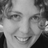

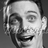

In [7]:
happy_images = list(data_dir_train.glob('happy/*'))
display(PIL.Image.open(str(happy_images[0])))

surprised_images = list(data_dir_train.glob('surprised/*'))
display(PIL.Image.open(str(surprised_images[0])))

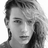

In [8]:
display(PIL.Image.open(str(happy_images[73])))

# Load data using a Keras utility

Let's load these images off disk using the helpful `tf.keras.utils.image_dataset_from_directory` utility. This will take you from a directory of images on disk to a `tf.data.Dataset` in just a couple lines of code.

## Create a dataset

Define some parameters for the loader:

In [9]:
batch_size = 32
img_height = 48
img_width = 48

Split your testing and training data to their designated space. 

In [10]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 28709 files belonging to 7 classes.


In [11]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_test,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 7178 files belonging to 7 classes.


You can find the class names in the `class_names` attribute on these datasets. These correspond to the directory names in alphabetical order.

In [12]:
class_names = train_ds.class_names
print(class_names)

['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']


## Visualize the data

Here are the first nine images from the training dataset:

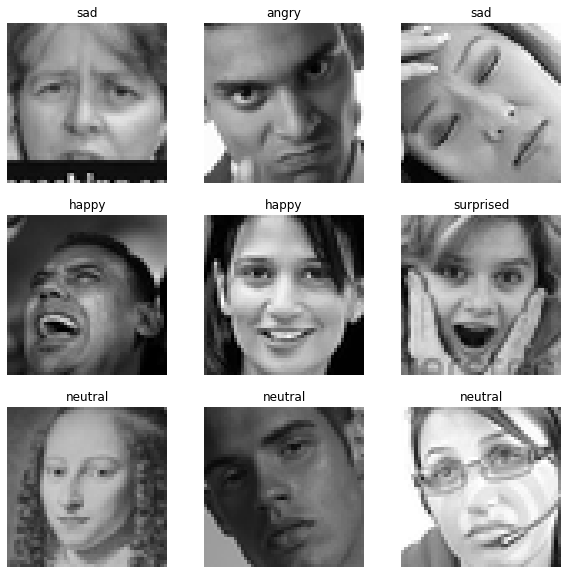

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [14]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 48, 48, 3)
(32,)


The `image_batch` is a tensor of the shape `(32, 48, 48, 3)`. This is a batch of 32 images of shape `48x48x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.


## Configure the dataset for performance
These are two important methods you should use when loading data so you can yield data from disk without having I/O become blocking:

- `Dataset.cache` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
- `Dataset.prefetch` overlaps data preprocessing and model execution while training.

In [15]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardize the data

The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network; in general you should seek to make your input values small.

Here, you will standardize values to be in the `[0, 1]` range by using `tf.keras.layers.Rescaling`:

In [16]:
normalization_layer = layers.Rescaling(1./255)

Applying layer to the dataset by calling `Dataset.map`:

In [17]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.011764707 0.9568628


# Implemented CNN
Implemented CNN is credited [SONYD4D's notebook](https://www.kaggle.com/code/sonyd4d/cnn-for-emotion-detection) from Kaggle.com



In [18]:
model = tf.keras.Sequential()

model.add(Conv2D(32,(3,3),padding='same',kernel_initializer='he_normal',input_shape=(48,48,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(32,(3,3),padding='same',kernel_initializer='he_normal',input_shape=(48,48,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))


model.add(Conv2D(64,(3,3),padding='same',kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(64,(3,3),padding='same',kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))


model.add(Conv2D(128,(3,3),padding='same',kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(128,(3,3),padding='same',kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))


model.add(Conv2D(256,(3,3),padding='same',kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(256,(3,3),padding='same',kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(64,kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))


model.add(Dense(64,kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))


model.add(Dense(7,kernel_initializer='he_normal'))
model.add(Activation('softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        896       
                                                                 
 activation (Activation)     (None, 48, 48, 32)        0         
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 48, 48, 32)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 48, 48, 32)       128       
 hNormalization)                                        

In [19]:
optimizer = tf.keras.optimizers.Adam(learning_rate= 0.005)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [20]:
epochs = 50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


898/898 [==============================] - 27s 15ms/step - loss: 2.0986 - accuracy: 0.2263 - val_loss: 1.6587 - val_accuracy: 0.3444
Epoch 2/50
898/898 [==============================] - 12s 13ms/step - loss: 1.6104 - accuracy: 0.3709 - val_loss: 1.5927 - val_accuracy: 0.4175
Epoch 3/50
898/898 [==============================] - 12s 13ms/step - loss: 1.4100 - accuracy: 0.4570 - val_loss: 1.2884 - val_accuracy: 0.4993
Epoch 4/50
898/898 [==============================] - 12s 13ms/step - loss: 1.3184 - accuracy: 0.5001 - val_loss: 1.3174 - val_accuracy: 0.4940
Epoch 5/50
898/898 [==============================] - 12s 13ms/step - loss: 1.2505 - accuracy: 0.5322 - val_loss: 1.1938 - val_accuracy: 0.5364
Epoch 6/50
898/898 [==============================] - 12s 13ms/step - loss: 1.2088 - accuracy: 0.5486 - val_loss: 1.1550 - val_accuracy: 0.5653
Epoch 7/50
898/898 [==============================] - 12s 13ms/step - loss: 1.1472 - accuracy: 0.5743 - val_loss: 1.1298 - val_accuracy: 0.5786
Epo

# Evaluation
As seen, the data findings created by original code is slightly less efficient that the modified code developed. A reason may be because the modified code also includes data augumentation while the original does not.

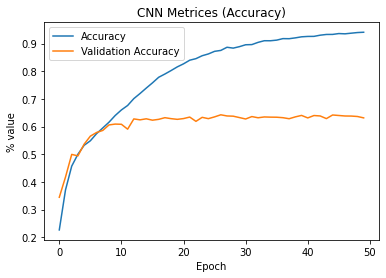

In [21]:
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('CNN Metrices (Accuracy)')
plt.ylabel('% value')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()

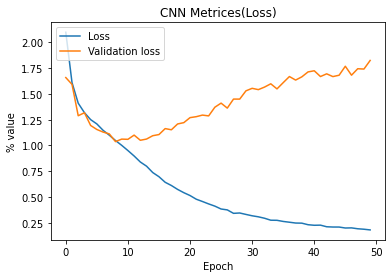

In [22]:
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('CNN Metrices(Loss)')
plt.ylabel('% value')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()



-----------------------------------------------------


## Data augmentation & Dropout

Data augmentation takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better. 
When you apply dropout to a layer, it randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process.

Implemented data augmentation and dropout using the following Keras preprocessing layers: `tf.keras.layers.RandomFlip`, `tf.keras.layers.RandomRotation`, and `tf.keras.layers.RandomZoom`, `tf.keras.layers.Dropout`.

In [23]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

A few augmented examples look like by applying data augmentation to the same image several times:

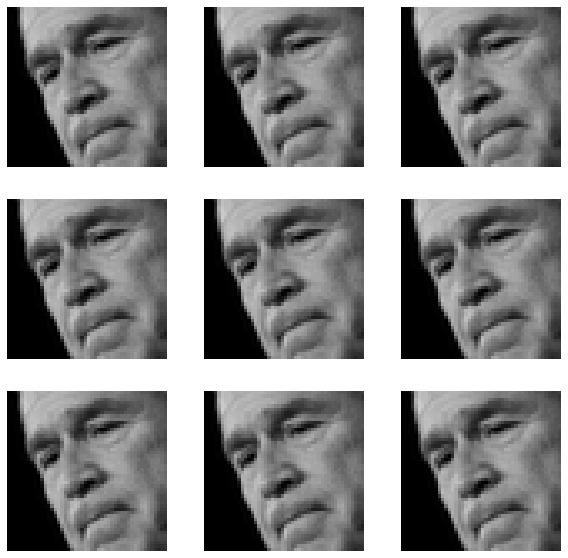

In [24]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

Implemented CNN is credited [SONYD4D's notebook](https://www.kaggle.com/code/sonyd4d/cnn-for-emotion-detection) from Kaggle.com



In [25]:
num_classes = len(class_names)

model = tf.keras.Sequential()
model.add(data_augmentation)
model.add(layers.Rescaling(1./255))
model.add(Conv2D(32,(3,3),padding='same',kernel_initializer='he_normal',input_shape=(48,48,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(32,(3,3),padding='same',kernel_initializer='he_normal',input_shape=(48,48,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))


model.add(Conv2D(64,(3,3),padding='same',kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(64,(3,3),padding='same',kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))


model.add(Conv2D(128,(3,3),padding='same',kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(128,(3,3),padding='same',kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))


model.add(Conv2D(256,(3,3),padding='same',kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(256,(3,3),padding='same',kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))


model.add(Flatten())
model.add(Dense(64,kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))


model.add(Dense(64,kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(num_classes))

## Compile and train the model

In [26]:
optimizer = tf.keras.optimizers.Adam(learning_rate= 0.005)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [27]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 48, 48, 3)         0         
                                                                 
 rescaling_1 (Rescaling)     (None, 48, 48, 3)         0         
                                                                 
 conv2d_8 (Conv2D)           (None, 48, 48, 32)        896       
                                                                 
 activation_11 (Activation)  (None, 48, 48, 32)        0         
                                                                 
 batch_normalization_10 (Bat  (None, 48, 48, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_9 (Conv2D)           (None, 48, 48, 32)        9248      
                                                      

In [28]:
epochs = 50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
898/898 [==============================] - 16s 15ms/step - loss: 2.0182 - accuracy: 0.2134 - val_loss: 1.8115 - val_accuracy: 0.2515
Epoch 2/50
898/898 [==============================] - 13s 15ms/step - loss: 1.7601 - accuracy: 0.2747 - val_loss: 1.7208 - val_accuracy: 0.3108
Epoch 3/50
898/898 [==============================] - 13s 15ms/step - loss: 1.6469 - accuracy: 0.3469 - val_loss: 1.5255 - val_accuracy: 0.3984
Epoch 4/50
898/898 [==============================] - 13s 15ms/step - loss: 1.5308 - accuracy: 0.4068 - val_loss: 1.4186 - val_accuracy: 0.4551
Epoch 5/50
898/898 [==============================] - 13s 15ms/step - loss: 1.4478 - accuracy: 0.4462 - val_loss: 1.4127 - val_accuracy: 0.4620
Epoch 6/50
898/898 [==============================] - 13s 15ms/step - loss: 1.3928 - accuracy: 0.4664 - val_loss: 1.2458 - val_accuracy: 0.5258
Epoch 7/50
898/898 [==============================] - 13s 15ms/step - loss: 1.3537 - accuracy: 0.4856 - val_loss: 1.2208 - val_accuracy:

## Visualize training results

After applying data augmentation and dropout, here is a visual of how our test and training data did:

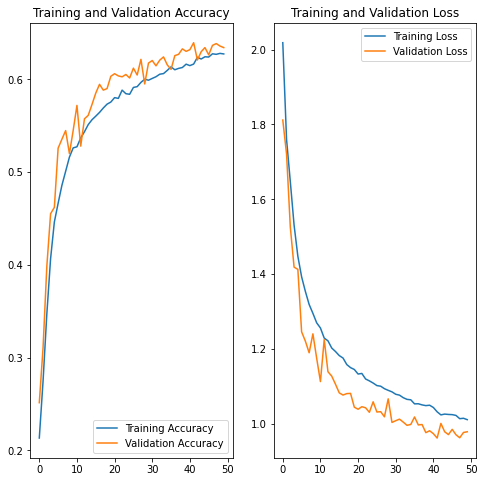

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()